<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020/blob/main/8_5_introduction_to_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.4.3'

# Introduction to generative adversarial networks

This notebook contains the second code sample found in Chapter 8, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---
Example from: https://github.com/polyaxon/deep-learning-with-python-notebooks-on-polyaxon/blob/master/8.5-introduction-to-gans.ipynb

## A schematic GAN implementation


In what follows, we explain how to implement a GAN in Keras, in its barest form -- since GANs are quite advanced, diving deeply into the 
technical details would be out of scope for us. Our specific implementation will be a deep convolutional GAN, or DCGAN: a GAN where the 
generator and discriminator are deep convnets. In particular, it leverages a `Conv2DTranspose` layer for image upsampling in the generator.

We will train our GAN on images from CIFAR10, a dataset of 50,000 32x32 RGB images belong to 10 classes (5,000 images per class). To make 
things even easier, we will only use images belonging to the class "frog".

Schematically, our GAN looks like this:

* A `generator` network maps vectors of shape `(latent_dim,)` to images of shape `(32, 32, 3)`.
* A `discriminator` network maps images of shape (32, 32, 3) to a binary score estimating the probability that the image is real.
* A `gan` network chains the generator and the discriminator together: `gan(x) = discriminator(generator(x))`. Thus this `gan` network maps 
latent space vectors to the discriminator's assessment of the realism of these latent vectors as decoded by the generator.
* We train the discriminator using examples of real and fake images along with "real"/"fake" labels, as we would train any regular image 
classification model.
* To train the generator, we use the gradients of the generator's weights with regard to the loss of the `gan` model. This means that, at 
every step, we move the weights of the generator in a direction that will make the discriminator more likely to classify as "real" the 
images decoded by the generator. I.e. we train the generator to fool the discriminator.

## A bag of tricks


Training GANs and tuning GAN implementations is notoriously difficult. There are a number of known "tricks" that one should keep in mind. 
Like most things in deep learning, it is more alchemy than science: these tricks are really just heuristics, not theory-backed guidelines. 
They are backed by some level of intuitive understanding of the phenomenon at hand, and they are known to work well empirically, albeit not 
necessarily in every context.

Here are a few of the tricks that we leverage in our own implementation of a GAN generator and discriminator below. It is not an exhaustive 
list of GAN-related tricks; you will find many more across the GAN literature.

* We use `tanh` as the last activation in the generator, instead of `sigmoid`, which would be more commonly found in other types of models.
* We sample points from the latent space using a _normal distribution_ (Gaussian distribution), not a uniform distribution.
* Stochasticity is good to induce robustness. Since GAN training results in a dynamic equilibrium, GANs are likely to get "stuck" in all sorts of ways. 
Introducing randomness during training helps prevent this. We introduce randomness in two ways: 1) we use dropout in the discriminator, 2) 
we add some random noise to the labels for the discriminator.
* Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. There are two things 
that can induce gradient sparsity: 1) max pooling operations, 2) ReLU activations. Instead of max pooling, we recommend using strided 
convolutions for downsampling, and we recommend using a `LeakyReLU` layer instead of a ReLU activation. It is similar to ReLU but it 
relaxes sparsity constraints by allowing small negative activation values.
* In generated images, it is common to see "checkerboard artifacts" caused by unequal coverage of the pixel space in the generator. To fix 
this, we use a kernel size that is divisible by the stride size, whenever we use a strided `Conv2DTranpose` or `Conv2D` in both the 
generator and discriminator.

## The generator


First, we develop a `generator` model, which turns a vector (from the latent space -- during training it will sampled at random) into a 
candidate image. One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like 
noise. A possible solution is to use dropout on both the discriminator and generator.

In [ ]:
import keras
from keras import layers
import numpy as np

import matplotlib.pyplot as plt

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048

## The discriminator


Then, we develop a `discriminator` model, that takes as input a candidate image (real or synthetic) and classifies it into one of two 
classes, either "generated image" or "real image that comes from the training set".

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 6, 6, 128)         0   

## The adversarial network

Finally, we setup the GAN, which chains the generator and the discriminator. This is the model that, when trained, will move the generator 
in a direction that improves its ability to fool the discriminator. This model turns latent space points into a classification decision, 
"fake" or "real", and it is meant to be trained with labels that are always "these are real images". So training `gan` will updates the 
weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images. Very importantly, we 
set the discriminator to be frozen during training (non-trainable): its weights will not be updated when training `gan`. If the 
discriminator weights could be updated during this process, then we would be training the discriminator to always predict "real", which is 
not what we want!

In [ ]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## How to train your DCGAN

Now we can start training. To recapitulate, this is schematically what the training loop looks like:

```
for each epoch:
    * Draw random points in the latent space (random noise).
    * Generate images with `generator` using this random noise.
    * Mix the generated images with real ones.
    * Train `discriminator` using these mixed images, with corresponding targets, either "real" (for the real images) or "fake" (for the generated images).
    * Draw new random points in the latent space.
    * Train `gan` using these random vectors, with targets that all say "these are real images". This will update the weights of the generator (only, since discriminator is frozen inside `gan`) to move them towards getting the discriminator to predict "these are real images" for generated images, i.e. this trains the generator to fool the discriminator.
```

Let's implement it:

mkdir: cannot create directory ‘./gan_images’: File exists
discriminator loss at step 0: 0.6927429437637329
adversarial loss at step 0: 0.6744805574417114


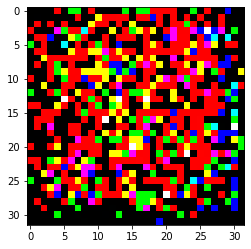

discriminator loss at step 100: 0.4452597498893738
adversarial loss at step 100: 2.207284450531006
discriminator loss at step 200: 0.7082707285881042
adversarial loss at step 200: 0.91810542345047
discriminator loss at step 300: 0.685383677482605
adversarial loss at step 300: 0.7528471946716309
discriminator loss at step 400: 0.7596415281295776
adversarial loss at step 400: 0.8430794477462769
discriminator loss at step 500: 0.6848816871643066
adversarial loss at step 500: 0.7672352194786072
discriminator loss at step 600: 0.6435898542404175
adversarial loss at step 600: 0.6951488256454468
discriminator loss at step 700: 0.7090535163879395
adversarial loss at step 700: 0.7209299802780151
discriminator loss at step 800: 0.6984829902648926
adversarial loss at step 800: 0.7498576045036316
discriminator loss at step 900: 0.6857793927192688
adversarial loss at step 900: 0.8308783769607544
discriminator loss at step 1000: 0.676712691783905
adversarial loss at step 1000: 0.6946625709533691


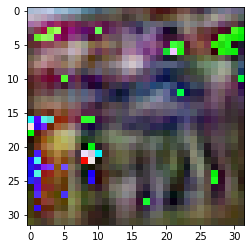

discriminator loss at step 1100: 0.7069072723388672
adversarial loss at step 1100: 0.7847469449043274
discriminator loss at step 1200: 0.7135587930679321
adversarial loss at step 1200: 0.7634729146957397
discriminator loss at step 1300: 0.7111269235610962
adversarial loss at step 1300: 0.7606122493743896
discriminator loss at step 1400: 0.7044271230697632
adversarial loss at step 1400: 0.7355758547782898
discriminator loss at step 1500: 0.6973847150802612
adversarial loss at step 1500: 0.7440527677536011
discriminator loss at step 1600: 0.677444338798523
adversarial loss at step 1600: 0.7265709638595581
discriminator loss at step 1700: 0.7010419964790344
adversarial loss at step 1700: 0.7025613784790039
discriminator loss at step 1800: 0.6855878233909607
adversarial loss at step 1800: 0.7403439879417419
discriminator loss at step 1900: 0.7044379115104675
adversarial loss at step 1900: 0.7394044995307922
discriminator loss at step 2000: 0.6836999654769897
adversarial loss at step 2000: 

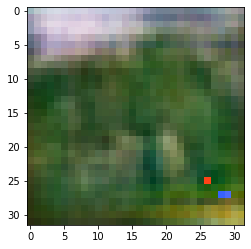

discriminator loss at step 2100: 0.7056568264961243
adversarial loss at step 2100: 0.8745891451835632
discriminator loss at step 2200: 0.70699143409729
adversarial loss at step 2200: 0.7442792057991028
discriminator loss at step 2300: 0.6909228563308716
adversarial loss at step 2300: 0.741162121295929
discriminator loss at step 2400: 0.707177460193634
adversarial loss at step 2400: 0.6591001749038696
discriminator loss at step 2500: 1.011664867401123
adversarial loss at step 2500: 0.7505279183387756
discriminator loss at step 2600: 0.6969002485275269
adversarial loss at step 2600: 0.7197033166885376
discriminator loss at step 2700: 0.8375359773635864
adversarial loss at step 2700: 0.7864182591438293
discriminator loss at step 2800: 0.6993916630744934
adversarial loss at step 2800: 0.7444726228713989
discriminator loss at step 2900: 0.7017871141433716
adversarial loss at step 2900: 0.747066080570221
discriminator loss at step 3000: 0.6811599135398865
adversarial loss at step 3000: 0.666

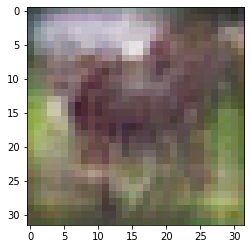

discriminator loss at step 3100: 0.6872850656509399
adversarial loss at step 3100: 0.6847514510154724
discriminator loss at step 3200: 0.6833073496818542
adversarial loss at step 3200: 0.8283430337905884
discriminator loss at step 3300: 0.6953855156898499
adversarial loss at step 3300: 0.7430726289749146
discriminator loss at step 3400: 0.6968501806259155
adversarial loss at step 3400: 0.7412368059158325
discriminator loss at step 3500: 0.6931620240211487
adversarial loss at step 3500: 0.707577645778656
discriminator loss at step 3600: 0.6851094961166382
adversarial loss at step 3600: 0.7603569030761719
discriminator loss at step 3700: 0.6921911835670471
adversarial loss at step 3700: 0.7542597055435181
discriminator loss at step 3800: 0.6936200261116028
adversarial loss at step 3800: 0.8186480402946472
discriminator loss at step 3900: 0.6954150795936584
adversarial loss at step 3900: 0.7328566908836365
discriminator loss at step 4000: 0.6839462518692017
adversarial loss at step 4000: 

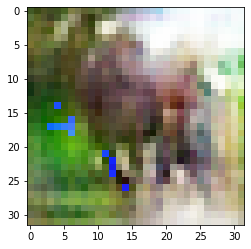

discriminator loss at step 4100: 0.6903553009033203
adversarial loss at step 4100: 0.768514096736908
discriminator loss at step 4200: 0.681099534034729
adversarial loss at step 4200: 0.7537434697151184
discriminator loss at step 4300: 0.7053521275520325
adversarial loss at step 4300: 0.688786506652832
discriminator loss at step 4400: 0.6991759538650513
adversarial loss at step 4400: 0.7605343461036682
discriminator loss at step 4500: 0.6741440892219543
adversarial loss at step 4500: 0.7364066243171692
discriminator loss at step 4600: 0.6912164092063904
adversarial loss at step 4600: 0.8155803680419922
discriminator loss at step 4700: 0.6923232078552246
adversarial loss at step 4700: 0.7620960474014282
discriminator loss at step 4800: 0.7061492204666138
adversarial loss at step 4800: 0.7387757897377014
discriminator loss at step 4900: 0.6973649263381958
adversarial loss at step 4900: 0.7882152795791626
discriminator loss at step 5000: 0.6902778744697571
adversarial loss at step 5000: 0.

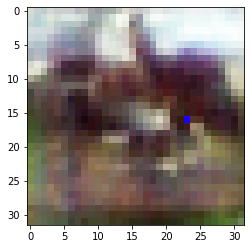

discriminator loss at step 5100: 0.6874933242797852
adversarial loss at step 5100: 0.8081655502319336
discriminator loss at step 5200: 0.6906692385673523
adversarial loss at step 5200: 0.7336744666099548
discriminator loss at step 5300: 0.6859421730041504
adversarial loss at step 5300: 0.7450437545776367
discriminator loss at step 5400: 0.6873763203620911
adversarial loss at step 5400: 0.874144434928894
discriminator loss at step 5500: 0.6914754509925842
adversarial loss at step 5500: 0.6939204931259155
discriminator loss at step 5600: 0.6881195902824402
adversarial loss at step 5600: 0.8268240094184875
discriminator loss at step 5700: 0.7009127140045166
adversarial loss at step 5700: 0.8140271902084351
discriminator loss at step 5800: 0.6978408098220825
adversarial loss at step 5800: 0.7831000685691833
discriminator loss at step 5900: 0.6846036314964294
adversarial loss at step 5900: 0.7455556392669678
discriminator loss at step 6000: 0.6654863357543945
adversarial loss at step 6000: 

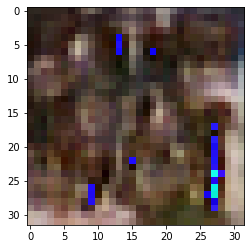

discriminator loss at step 6100: 0.7172374725341797
adversarial loss at step 6100: 0.7439225316047668
discriminator loss at step 6200: 0.6883742213249207
adversarial loss at step 6200: 0.7663828730583191
discriminator loss at step 6300: 0.6896024942398071
adversarial loss at step 6300: 0.7668276429176331
discriminator loss at step 6400: 0.6804329752922058
adversarial loss at step 6400: 0.8242292404174805
discriminator loss at step 6500: 0.6877425909042358
adversarial loss at step 6500: 0.759763240814209
discriminator loss at step 6600: 0.6799920201301575
adversarial loss at step 6600: 0.7904890179634094
discriminator loss at step 6700: 0.6913437843322754
adversarial loss at step 6700: 0.6888691186904907
discriminator loss at step 6800: 0.6849309206008911
adversarial loss at step 6800: 0.7895412445068359
discriminator loss at step 6900: 0.6762512922286987
adversarial loss at step 6900: 0.7399457693099976
discriminator loss at step 7000: 0.6874494552612305
adversarial loss at step 7000: 

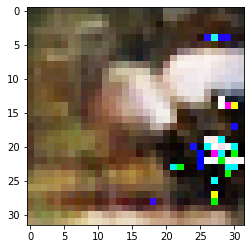

discriminator loss at step 7100: 0.6896994709968567
adversarial loss at step 7100: 0.7712929248809814
discriminator loss at step 7200: 0.6674688458442688
adversarial loss at step 7200: 0.7678160667419434
discriminator loss at step 7300: 0.6916083097457886
adversarial loss at step 7300: 0.7569937705993652
discriminator loss at step 7400: 0.705539345741272
adversarial loss at step 7400: 0.7989654541015625
discriminator loss at step 7500: 0.7200679183006287
adversarial loss at step 7500: 0.9132193326950073
discriminator loss at step 7600: 0.7005869150161743
adversarial loss at step 7600: 0.7213205099105835
discriminator loss at step 7700: 0.7006348371505737
adversarial loss at step 7700: 0.8070842623710632
discriminator loss at step 7800: 0.6995037198066711
adversarial loss at step 7800: 0.8357422947883606
discriminator loss at step 7900: 0.709537148475647
adversarial loss at step 7900: 0.7280569672584534
discriminator loss at step 8000: 0.7006450295448303
adversarial loss at step 8000: 0

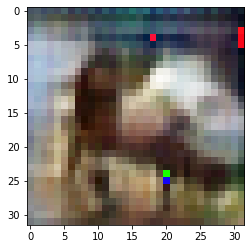

discriminator loss at step 8100: 0.697547435760498
adversarial loss at step 8100: 0.8019521832466125
discriminator loss at step 8200: 0.7018076181411743
adversarial loss at step 8200: 0.7647474408149719
discriminator loss at step 8300: 0.686759889125824
adversarial loss at step 8300: 0.6969931125640869
discriminator loss at step 8400: 0.7011516690254211
adversarial loss at step 8400: 0.7841377258300781
discriminator loss at step 8500: 0.9784997701644897
adversarial loss at step 8500: 0.7271590232849121
discriminator loss at step 8600: 0.6919147372245789
adversarial loss at step 8600: 0.7647259831428528
discriminator loss at step 8700: 0.7077261209487915
adversarial loss at step 8700: 0.713117241859436
discriminator loss at step 8800: 0.6820273399353027
adversarial loss at step 8800: 0.7413581013679504
discriminator loss at step 8900: 0.6932341456413269
adversarial loss at step 8900: 0.7808815836906433
discriminator loss at step 9000: 0.7042351365089417
adversarial loss at step 9000: 0.

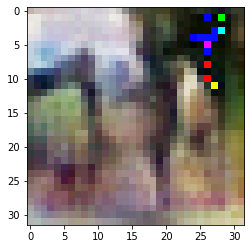

discriminator loss at step 9100: 0.6901533603668213
adversarial loss at step 9100: 0.6885877251625061
discriminator loss at step 9200: 0.6986222267150879
adversarial loss at step 9200: 0.836168110370636
discriminator loss at step 9300: 0.6914234161376953
adversarial loss at step 9300: 0.9646309614181519
discriminator loss at step 9400: 0.689848780632019
adversarial loss at step 9400: 0.7606331706047058
discriminator loss at step 9500: 0.6843140125274658
adversarial loss at step 9500: 0.7521613240242004
discriminator loss at step 9600: 0.7166826128959656
adversarial loss at step 9600: 0.5888754725456238
discriminator loss at step 9700: 0.6955410838127136
adversarial loss at step 9700: 0.7725507020950317
discriminator loss at step 9800: 0.6918187141418457
adversarial loss at step 9800: 0.7390627861022949
discriminator loss at step 9900: 0.7587635517120361
adversarial loss at step 9900: 0.7298874855041504


In [ ]:
import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select horse images (class 7)
x_train = x_train[y_train.flatten() == 7]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
! mkdir ./gan_images
save_dir = './gan_images/'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_horse' + str(step) + '.png'))

        if step % 1000 == 0:
          # Show generated image
          plt.figure()
          plt.imshow(img)
          plt.show()

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_horse' + str(step) + '.png'))

Let's display a few of our fake images:

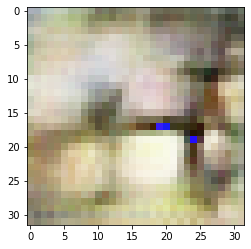

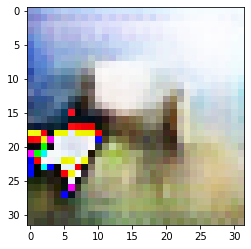

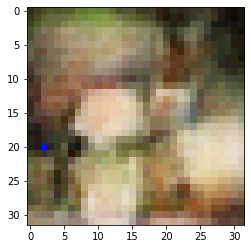

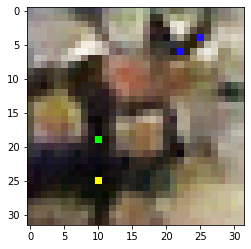

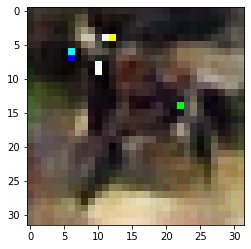

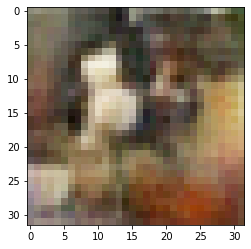

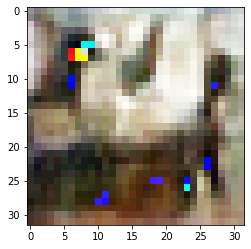

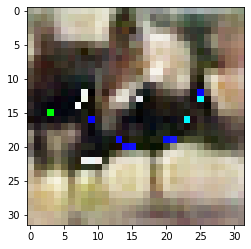

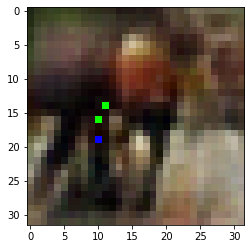

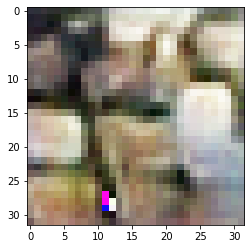

In [ ]:


# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(20, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

Horse with some pixellated artifacts.